# Lab 4: Sequential Data

This lab is based on an assignment developed by Prof. Lisa Zhang.

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.
5. Understand how transfer learning can be applied to NLP projects.

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1Co0DNFbn1AjiXIkkCCAefMOiHb4Pj39G/view?usp=sharing

# PART A - Spam Detection [30 pt]

In this part we will construct a LSTM model for identifying spam from non spam messages.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [10 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [1 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/My Drive/MASc First Year/MIE1517/Lab4/smsspamcollection/SMSSpamCollection'
is_ham = False
is_spam = False
for line in open(folder_path):
    if line[0:3] == "ham" and not is_ham:
        print(line)
        is_ham = True
    if line[0:4] == "spam" and not is_spam:
        print(line)
        is_spam = True
    if is_ham and is_spam:
        break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



In [ ]:
# for line in open(folder_path):
#     break

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
count_ham = 0
count_spam = 0

for line in open(folder_path):
  if line[0:3] == "ham":
    count_ham += 1
  if line[0:4] == "spam":
    count_spam += 1

print("Number of Ham Messages: " + str(count_ham))
print("Number of Spam Messages: " + str(count_spam))

Number of Ham Messages: 4827
Number of Spam Messages: 747


### Part (c) [2 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

In [ ]:
# Advantage 1: Working with a sequence of characters is that the discrete 
# space we work with is much smaller. There are about 97 English-language 
# characters in common usage including all punctuation marks. However, a 
# working with a sequence of words implies that storing the word embeddings 
# requires a lot of memory, many parameters to the model so the computational 
# cost is much higher on this account than the character-level model.

# Advantage 2: Mispelled words or other words not appearing in the embeddings are 
# usually treated as unknown token. Using characters rather than the embeddings
# is more flexible working with misppelled words.

# Disadvantage 1: working with sequence of words would produce more 
# parameters, which makes computationally expensive

# Disadvantage 2: only working with characers would have difficulty to capture 
# long distinct dependencies, and without working with words will include nonsense 
# words or obvious typos in text, result in lots of noise.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [4]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.legacy.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset(folder_path, # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)

# dataset[0].sms
# dataset[0].label
# train, valid, test = ...
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

In [5]:
n=0
for i in train.examples:
    print(i.sms)
    print(i.label)
    n+=1
    if n > 3:
        break

I place all ur points on e cultures module already.
0
No one interested. May be some business plan.
0
Hows the champ just leaving glasgow!
0
Congratulations ur awarded either a yrs supply of CDs from Virgin Records or a Mystery Gift GUARANTEED Call 09061104283 Ts&Cs www.smsco.net £1.50pm approx 3mins
1


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [6]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

# Our training data has more ham messages, so the trained model will be biased and
# tend to label messages as ham than spam, results in false negatives (falsely 
# label spam messages as ham). This will ultimately cause inaccurate prediction 
# at the end.

In [ ]:
print(len(train.examples))
count = 0
for item in train.examples:
    if item.label == 1:
        count+=1
print(count)

5929
3017


In [ ]:
print(len(valid.examples))
count = 0
for item in valid.examples:
    if item.label == 1:
        count+=1
print(count)

1115
162


In [ ]:
print(len(test.examples))
count = 0
for item in test.examples:
    if item.label == 1:
        count+=1
print(count)

1114
154


### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [8]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

# vocab.stoi is a dictionary, which maps character to numbers
# vocab.itos is list of characters, which are the keys of the vocab.stoi dictionary.

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7fc95ec6ec10>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, 'd': 14, '0': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, 'f': 23, '1': 24, 'b': 25, '2': 26, 'T': 27, 'k': 28, '8': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'I': 34, 'C': 35, 'O': 36, 'A': 37, 'N': 38, '4': 39, 'x': 40, 'R': 41, '7': 42, '6': 43, '3': 44, ',': 45, '9': 46, '!': 47, 'M': 48, 'P': 49, 'U': 50, 'W': 51, 'L': 52, 'H': 53, 'D': 54, 'F': 55, 'G': 56, 'B': 57, 'Y': 58, "'": 59, '?': 60, '/': 61, '£': 62, '&': 63, '-': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, ')': 71, '*': 72, 'J': 73, ';': 74, '+': 75, '(': 76, 'q': 77, '"': 78, '#': 79, '>': 80, 'Q': 81, '@': 82, 'Z': 83, '=': 84, 'ü': 85, '<': 86, '$': 87, '|': 88, 'Ü': 89, '‘': 90, '[': 91, ']': 92, '\x92': 93, '_': 94, '“': 95, '%': 96, '…': 97, '’':

### Part (g) [1 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

In [ ]:
# <unk> means "unknown token" which is used to replace the rare words that did not 
# fit in our vocabulary. For example, "My name is huyouzhi112" will be translated 
# into My name is _unk_.
# <pad> is my GPU processes the training data in batches and all the sequences in 
# the batch should have the same length. If the max length of the sequence is 6, 
# "My name is huyouzhi112" will be padded from either side to fit this length: 
# My name is huyouzhi112 _pad_ _pad_

### Part (h) [1 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [9]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding - order in length
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [10]:
i = 1
for batch in train_iter:
    print(batch.sms[0].size()) # size of batch x max num of chracters within this batch
    # print(batch.sms[0])
    # print(len(batch.sms[0][0])) # longest setence: max num of characters
    # print(batch.sms[1].size())
    print(torch.empty(32).fill_(len(batch.sms[0][0]))) 
    # set every sentence in the batch with the max num of characters
    # subtract the actual length from the max num of characters to get the 
    # count of padthe pad, since each pad = 1
    print(batch.sms[1])

    i+=1
    if i == 3:
        break
# count how many 1 in each line to get count of pads

torch.Size([32, 165])
tensor([165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
        165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165., 165.,
        165., 165., 165., 165., 165., 165., 165., 165.])
tensor([165, 165, 165, 165, 165, 165, 165, 165, 164, 163, 163, 163, 163, 163,
        163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163, 163,
        163, 163, 162, 162])
torch.Size([32, 21])
tensor([21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
        21., 21., 21., 21.])
tensor([21, 21, 21, 21, 21, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 18, 18, 18,
        17, 17, 17, 17, 16, 16, 16, 15, 15, 15, 15, 14, 14, 14])


In [11]:
# for batch in train_iter:

#     break
    #print(len(batch))
    #print(batch.sms)
    #print(batch.label)

i = 1
for batch in train_iter:
    pads = torch.empty(32).fill_(len(batch.sms[0][0])) -  batch.sms[1]
    print(f"Batch {i} - max input sequence {len(batch.sms[0][0])}, number of pads {pads.sum()}")
    i+=1
    if i == 11:
        break

Batch 1 - max input sequence 32, number of pads 4.0
Batch 2 - max input sequence 145, number of pads 0.0
Batch 3 - max input sequence 53, number of pads 14.0
Batch 4 - max input sequence 55, number of pads 18.0
Batch 5 - max input sequence 103, number of pads 64.0
Batch 6 - max input sequence 132, number of pads 10.0
Batch 7 - max input sequence 154, number of pads 0.0
Batch 8 - max input sequence 75, number of pads 44.0
Batch 9 - max input sequence 146, number of pads 4.0
Batch 10 - max input sequence 34, number of pads 32.0


## Part 2. Model Building [5 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class sdRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(sdRNN, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x] # embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) # Pass the output of the last time step to the classifier
        return out

In [ ]:
m1 = sdRNN(len(text_field.vocab), len(text_field.vocab), 2)
for param in m1.parameters():
    print(param.shape)
print(sum(p.numel() for p in m1.parameters()))

torch.Size([114, 114])
torch.Size([114, 114])
torch.Size([114])
torch.Size([114])
torch.Size([2, 114])
torch.Size([2])
26450


## Part 3. Training [8 pt]

### Part (a) [2 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for batch in data:
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.label.shape[0]
    return correct/total

### Part (b) [2 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
import matplotlib.pyplot as plt
def data_iter(data, batchsize = 32):
    return torchtext.legacy.data.BucketIterator(data,
                                           batch_size=batchsize,
                                           sort_key=lambda x: len(x.sms),
                                           sort_within_batch=True,
                                           repeat=False)

def train_rnn_network(model, train, val, num_epochs=10, learning_rate=1e-3, batch_size = 32):

    train_data = data_iter(train, batch_size)
    val_data = data_iter(val, batch_size)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    losses, train_acc, val_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for batch in train_data:
            optimizer.zero_grad()
            pred = model(batch.sms[0])
            loss = criterion(pred, batch.label)
            loss.backward()
            optimizer.step()
        
        losses.append(loss.item())
        train_acc.append(get_accuracy(model, train_data)) 
        val_acc.append(get_accuracy(model, val_data))
        epochs.append(epoch)

        print(f"Epoch {epoch}, Loss: {losses[-1]}, Train_Acc: {train_acc[-1]}, Val_Acc:{val_acc[-1]}")
    
    # plotting
    plt.title("Loss")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

### Part (c) [2 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

The hyperparamters are tuned in this sections are:
1. Adding a max-pooling before linear layer
2. Adding a max-pooling and mean-pooling before linear layer
3. Using different input and hidden size instead of the vocab dictionary length

After finding the best combination of hyperparameters unrelated to the optimizer, we tune:
4. number of epochs
5. learning rate

I finally tried with LSTM and GRU (same learning rate, epochs, batch size) to compare with my best RNN model to find out the overall best model.


Epoch 0, Loss: 0.6579574942588806, Train_Acc: 0.7290031724828853, Val_Acc:0.7892376681614349
Epoch 1, Loss: 0.35040536522865295, Train_Acc: 0.9111704792118884, Val_Acc:0.9390134529147982
Epoch 2, Loss: 0.22312359511852264, Train_Acc: 0.9198530639505761, Val_Acc:0.915695067264574
Epoch 3, Loss: 0.08035586774349213, Train_Acc: 0.926531975288028, Val_Acc:0.9551569506726457
Epoch 4, Loss: 0.2583063244819641, Train_Acc: 0.9338787777592252, Val_Acc:0.9587443946188341
Epoch 5, Loss: 0.1759716272354126, Train_Acc: 0.9397228251794958, Val_Acc:0.9560538116591928
Epoch 6, Loss: 0.5709732174873352, Train_Acc: 0.9260310569377191, Val_Acc:0.95695067264574
Epoch 7, Loss: 0.34743258357048035, Train_Acc: 0.6707296710636166, Val_Acc:0.4798206278026906
Epoch 8, Loss: 0.6381486058235168, Train_Acc: 0.7463683419602605, Val_Acc:0.6905829596412556
Epoch 9, Loss: 0.5239244699478149, Train_Acc: 0.800133578226749, Val_Acc:0.7713004484304933
Epoch 10, Loss: 0.3812101185321808, Train_Acc: 0.831858407079646, Val_A

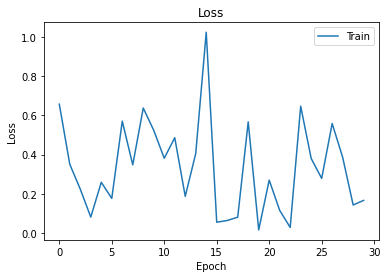

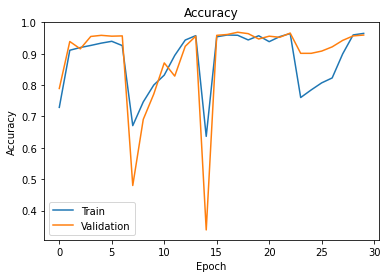

In [ ]:
# Original Model, input and hidden size = vocab dictionary length = 112
# epoch = 30, learning_rate = 0.0001, batch size = 32
model1 = sdRNN(len(text_field.vocab), len(text_field.vocab), 2)
train_rnn_network(model1, train, valid, num_epochs=30, learning_rate=0.0001, batch_size = 32)

In [ ]:
# Second Model with max-pooling, input and hidden size = vocab dictionary length = 112
# epoch = 30, learning_rate = 0.0001, batch size = 32
# By max-pooling to capture key information, the performance became more accurate and stable
class sdRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(sdRNN2, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x] # embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # out, _ = self.rnn(x)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

In [ ]:
m2 = sdRNN2(len(text_field.vocab), len(text_field.vocab), 2)
for param in m2.parameters():
    print(param.shape)
print(sum(p.numel() for p in m2.parameters()))

torch.Size([114, 114])
torch.Size([114, 114])
torch.Size([114])
torch.Size([114])
torch.Size([2, 114])
torch.Size([2])
26450


Epoch 0, Loss: 0.671817421913147, Train_Acc: 0.9345466688929704, Val_Acc:0.9022421524663677
Epoch 1, Loss: 0.3684113025665283, Train_Acc: 0.9245283018867925, Val_Acc:0.9291479820627803
Epoch 2, Loss: 0.1757138967514038, Train_Acc: 0.9492402738353648, Val_Acc:0.9668161434977578
Epoch 3, Loss: 0.22773043811321259, Train_Acc: 0.9484054099181833, Val_Acc:0.9641255605381166
Epoch 4, Loss: 0.20270004868507385, Train_Acc: 0.9572549674403072, Val_Acc:0.9659192825112107
Epoch 5, Loss: 0.13831180334091187, Train_Acc: 0.9635999332108867, Val_Acc:0.9650224215246637
Epoch 6, Loss: 0.19514602422714233, Train_Acc: 0.9512439472366004, Val_Acc:0.9282511210762332
Epoch 7, Loss: 0.029906585812568665, Train_Acc: 0.964935715478377, Val_Acc:0.9668161434977578
Epoch 8, Loss: 0.05419986695051193, Train_Acc: 0.9497411921856738, Val_Acc:0.967713004484305
Epoch 9, Loss: 0.044569265097379684, Train_Acc: 0.9627650692937051, Val_Acc:0.9641255605381166
Epoch 10, Loss: 0.10269815474748611, Train_Acc: 0.96944398063115

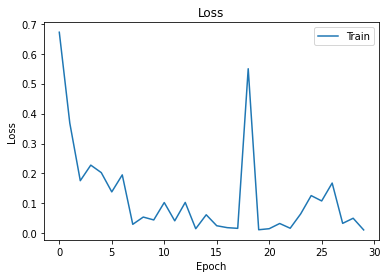

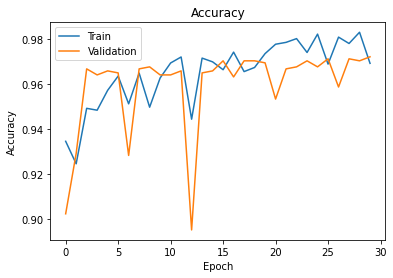

In [ ]:
model2 = sdRNN2(len(text_field.vocab), len(text_field.vocab), 2)
train_rnn_network(model2, train, valid, num_epochs=30, learning_rate=0.0001, batch_size = 32)

In [ ]:
# Third Model with max-pooling and mean-pooling, input and hidden size = vocab dictionary length = 112
# epoch = 30, learning_rate = 0.0001, batch size = 32
# By having a combination of max-pooling and mean-pooling, the network has 
# slightly more parameters, which becomes more powerful. Performance became better
class sdRNN3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(sdRNN3, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x] # embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
m3 = sdRNN3(len(text_field.vocab), len(text_field.vocab), 2)
for param in m3.parameters():
    print(param.shape)
print(sum(p.numel() for p in m3.parameters()))

torch.Size([114, 114])
torch.Size([114, 114])
torch.Size([114])
torch.Size([114])
torch.Size([2, 228])
torch.Size([2])
26678


Epoch 0, Loss: 0.6815395355224609, Train_Acc: 0.9021539489063283, Val_Acc:0.8609865470852018
Epoch 1, Loss: 0.5192002058029175, Train_Acc: 0.88311905159459, Val_Acc:0.9533632286995516
Epoch 2, Loss: 0.1923137605190277, Train_Acc: 0.9373852062113875, Val_Acc:0.9004484304932735
Epoch 3, Loss: 0.19031105935573578, Train_Acc: 0.9550843212556354, Val_Acc:0.9219730941704036
Epoch 4, Loss: 0.10593082755804062, Train_Acc: 0.9620971781599599, Val_Acc:0.9650224215246637
Epoch 5, Loss: 0.06947948783636093, Train_Acc: 0.9647687426949407, Val_Acc:0.9408071748878923
Epoch 6, Loss: 0.09610774368047714, Train_Acc: 0.9681081983636667, Val_Acc:0.9443946188340807
Epoch 7, Loss: 0.10904957354068756, Train_Acc: 0.9338787777592252, Val_Acc:0.8807174887892377
Epoch 8, Loss: 0.013215401209890842, Train_Acc: 0.9532476206378361, Val_Acc:0.9748878923766816
Epoch 9, Loss: 0.0198516882956028, Train_Acc: 0.9737852730005009, Val_Acc:0.9713004484304932
Epoch 10, Loss: 0.06743339449167252, Train_Acc: 0.975121055267991

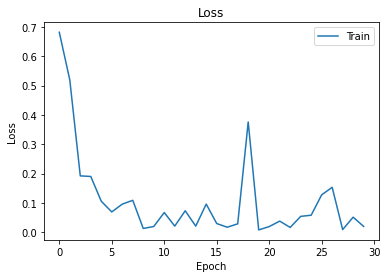

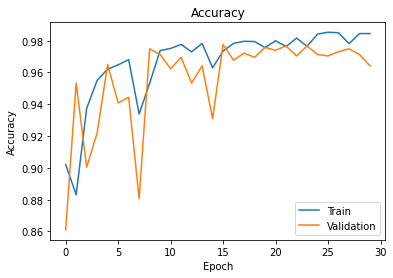

In [ ]:
model3 = sdRNN3(len(text_field.vocab), len(text_field.vocab), 2)
train_rnn_network(model3, train, valid, num_epochs=30, learning_rate=0.0001, batch_size = 32)

Epoch 0, Loss: 0.6712974309921265, Train_Acc: 0.9459008181666388, Val_Acc:0.9228699551569507
Epoch 1, Loss: 0.34489795565605164, Train_Acc: 0.9248622474536651, Val_Acc:0.957847533632287
Epoch 2, Loss: 0.13703477382659912, Train_Acc: 0.9530806478543997, Val_Acc:0.9488789237668162
Epoch 3, Loss: 0.62530517578125, Train_Acc: 0.9589246952746703, Val_Acc:0.9614349775784753
Epoch 4, Loss: 0.1574198454618454, Train_Acc: 0.9589246952746703, Val_Acc:0.9587443946188341
Epoch 5, Loss: 0.11196616291999817, Train_Acc: 0.9647687426949407, Val_Acc:0.9641255605381166
Epoch 6, Loss: 0.2730649411678314, Train_Acc: 0.9619302053765236, Val_Acc:0.9659192825112107
Epoch 7, Loss: 0.024451373144984245, Train_Acc: 0.9574219402237435, Val_Acc:0.9650224215246637
Epoch 8, Loss: 0.01979576237499714, Train_Acc: 0.9485723827016196, Val_Acc:0.968609865470852
Epoch 9, Loss: 0.031027797609567642, Train_Acc: 0.9677742527967941, Val_Acc:0.9650224215246637
Epoch 10, Loss: 0.11826388537883759, Train_Acc: 0.9619302053765236

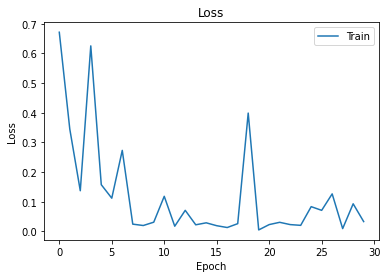

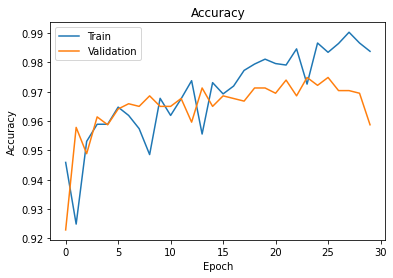

In [ ]:
# Using the third model (since it has the best performance out of the three 
# architectures), with a different input and hidden size = 200 (increased from 
# 112 to 200 for both input and hidden size), which results more parameters, so 
# the model became more powerful.
# epoch = 30, learning_rate = 0.0001, batch size = 32
# By increasing the input and hidden size of the network, the model starts to 
# overfit to the training data
model3_size200 = sdRNN3(200, 200, 2)
train_rnn_network(model3_size200, train, valid, num_epochs=30, learning_rate=0.0001, batch_size = 32)

Epoch 0, Loss: 0.3791210353374481, Train_Acc: 0.9095007513775255, Val_Acc:0.9632286995515695
Epoch 1, Loss: 0.06571437418460846, Train_Acc: 0.943730171981967, Val_Acc:0.9704035874439462
Epoch 2, Loss: 0.028369391337037086, Train_Acc: 0.9584237769243613, Val_Acc:0.967713004484305
Epoch 3, Loss: 0.07410354912281036, Train_Acc: 0.9707797628986475, Val_Acc:0.9695067264573991
Epoch 4, Loss: 0.055260129272937775, Train_Acc: 0.9714476540323927, Val_Acc:0.967713004484305
Epoch 5, Loss: 0.08490364253520966, Train_Acc: 0.9669393888796126, Val_Acc:0.9614349775784753
Epoch 6, Loss: 0.08883395791053772, Train_Acc: 0.9736183002170646, Val_Acc:0.967713004484305
Epoch 7, Loss: 0.07048139721155167, Train_Acc: 0.9834696944398064, Val_Acc:0.9766816143497757
Epoch 8, Loss: 0.1260024607181549, Train_Acc: 0.9864752045416597, Val_Acc:0.9704035874439462
Epoch 9, Loss: 0.024010349065065384, Train_Acc: 0.9781265653698448, Val_Acc:0.9542600896860987
Epoch 10, Loss: 0.022420495748519897, Train_Acc: 0.995324762063

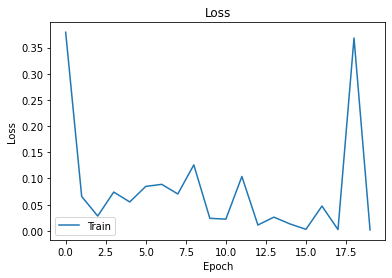

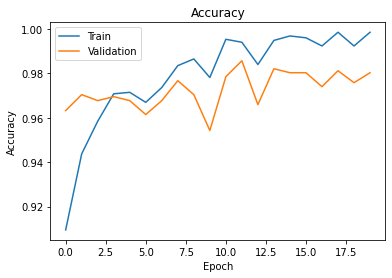

In [ ]:
# BEST
# Using the third model (since it has the best performance out of the three 
# architectures), with a slighly reduced input and hidden size = 150 (reduced
# from 200 to 120 for both input and hidden size)
# epoch = 20, learning_rate = 0.001, batch size = 64
# By increasing the input and hidden size of the network slighly from 112 to 
# 120 with the architecture of max and meaning pooling, the model has more 
# parameters to work with (more powerful). However, we saw overfitting to the
# training data (98.38%)because the validation set accuracy was only 95.87%.
# A smaller input and hidden size was decided with larger batch combined with 
# faster learning rate and less number of epochs to prevent overfitting.
# The loss reaches 0.0018652499420568347
model3_size120_lr0001_bs64 = sdRNN3(120, 120, 2)
train_rnn_network(model3_size120_lr0001_bs64, train, valid, num_epochs=20, learning_rate=0.001, batch_size = 64)
# Best Train_Acc: 0.9984972449490733
# Best Val_Acc:0.9802690582959641

In [ ]:
# LSTM can capture long term memory to prevent vanishing gradient.
# There are more parameters with LSTM, the final result is similar to the RNN 
# model. However the loss is slightly greater than the RNN model.
# Loss reaches 0.004350489471107721 (> RNN Loss = 0.0018652499420568347)
class sdRNN4(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(sdRNN4, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x] # embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, (h0,c0))
        # out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
m4 = sdRNN4(len(text_field.vocab), len(text_field.vocab), 2)
for param in m4.parameters():
    print(param.shape)
print(sum(p.numel() for p in m4.parameters()))

torch.Size([452, 113])
torch.Size([452, 113])
torch.Size([452])
torch.Size([452])
torch.Size([2, 226])
torch.Size([2])
103510


Epoch 0, Loss: 0.42979755997657776, Train_Acc: 0.9075729465339855, Val_Acc:0.97847533632287
Epoch 1, Loss: 0.16855184733867645, Train_Acc: 0.9215719345589476, Val_Acc:0.97847533632287
Epoch 2, Loss: 1.0895280838012695, Train_Acc: 0.6355203238320122, Val_Acc:0.43946188340807174
Epoch 3, Loss: 0.6198501586914062, Train_Acc: 0.7709563164108618, Val_Acc:0.6789237668161435
Epoch 4, Loss: 0.2256786823272705, Train_Acc: 0.8767077078765391, Val_Acc:0.8125560538116592
Epoch 5, Loss: 0.023599667474627495, Train_Acc: 0.8912126834204757, Val_Acc:0.8654708520179372
Epoch 6, Loss: 0.43286198377609253, Train_Acc: 0.8743464327879912, Val_Acc:0.7766816143497758
Epoch 7, Loss: 0.2531030476093292, Train_Acc: 0.9168493843818519, Val_Acc:0.8708520179372198
Epoch 8, Loss: 0.4841182827949524, Train_Acc: 0.9075729465339855, Val_Acc:0.8242152466367713
Epoch 9, Loss: 0.4298458993434906, Train_Acc: 0.9043683589138135, Val_Acc:0.8331838565022421
Epoch 10, Loss: 0.16477277874946594, Train_Acc: 0.9558104233428909, 

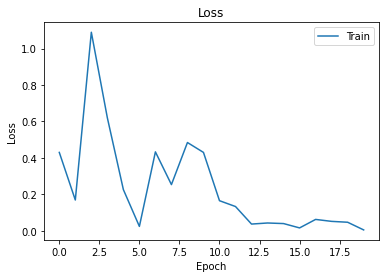

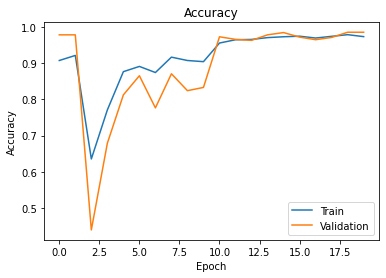

In [ ]:
model4 = sdRNN4(120, 120, 2)
train_rnn_network(model4, train, valid, num_epochs=20, learning_rate=0.001, batch_size = 64)

In [ ]:
# GRU's bag has two gates that are reset and update while LSTM has three gates 
# that are input, output, forget. GRU is less complex than LSTM because it 
# has less number of gates. So here the parameters in GRU is also less than 
# the previous LSTM. GRU also exposes the complete memory and hidden layers but 
# LSTM doesn't.
# The performance of GRU is similar to RNN and LSTM, its loss 
# (0.010127626359462738) is still greater than RNN loss (0.0018652499420568347)
class sdRNN5(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(sdRNN5, self).__init__()
        self.emb = torch.eye(hidden_size)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x] # embedding
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        # out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        return out

In [ ]:
m5 = sdRNN5(len(text_field.vocab), len(text_field.vocab), 2)
for param in m5.parameters():
    print(param.shape)
print(sum(p.numel() for p in m5.parameters()))

torch.Size([339, 113])
torch.Size([339, 113])
torch.Size([339])
torch.Size([339])
torch.Size([2, 226])
torch.Size([2])
77746


Epoch 0, Loss: 0.39725035429000854, Train_Acc: 0.9434980603811772, Val_Acc:0.9443946188340807
Epoch 1, Loss: 0.18117153644561768, Train_Acc: 0.9165120593692022, Val_Acc:0.979372197309417
Epoch 2, Loss: 0.12522689998149872, Train_Acc: 0.9423174228369033, Val_Acc:0.9757847533632287
Epoch 3, Loss: 0.07563474774360657, Train_Acc: 0.9517625231910947, Val_Acc:0.9757847533632287
Epoch 4, Loss: 0.28275930881500244, Train_Acc: 0.9561477483555406, Val_Acc:0.9757847533632287
Epoch 5, Loss: 0.08143922686576843, Train_Acc: 0.9660988362287064, Val_Acc:0.9730941704035875
Epoch 6, Loss: 0.04059130698442459, Train_Acc: 0.9681227863046045, Val_Acc:0.9775784753363229
Epoch 7, Loss: 0.005006052553653717, Train_Acc: 0.9649181986844324, Val_Acc:0.9829596412556054
Epoch 8, Loss: 0.08067122101783752, Train_Acc: 0.9731826614943498, Val_Acc:0.979372197309417
Epoch 9, Loss: 0.03770466521382332, Train_Acc: 0.9741946365322989, Val_Acc:0.9847533632286996
Epoch 10, Loss: 0.03553371503949165, Train_Acc: 0.97284533648

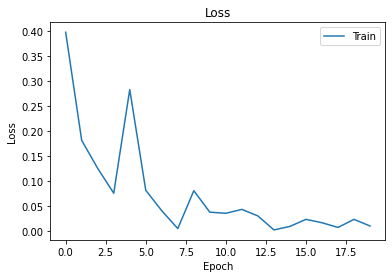

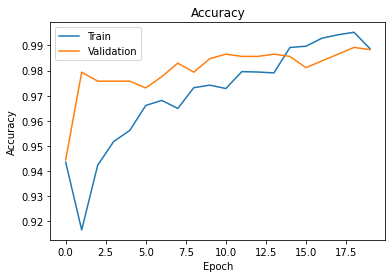

In [ ]:
model5 = sdRNN5(120, 120, 2)
train_rnn_network(model5, train, valid, num_epochs=20, learning_rate=0.001, batch_size = 64)

The best performance model is the third RNN model with input and hidden size = 120, epoch = 20, learning_rate = 0.001, batch size = 64. LSTM and GRU are very powerful; however, using RNN can already reached very good performance which has the smallest loss (0.0018652499420568347). So I decide to use my RNN model as the best model for Part B.

*   Loss: 0.0018652499420568347
*   Train_Acc: 0.9984972449490733
*   Val_Acc:0.9802690582959641


### Part (d) [1 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# False Negative: true label = spam, predicted label = non-spam
# False Positive: true label = non-spam, predicted label = spam

# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
spam = data_iter(valid_spam, 32)
FN = (1 - get_accuracy(model3_size120_lr0001_bs64, spam)) * 100
# get_accuracy(model, spam) is TP

# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)
nospam = data_iter(valid_nospam, 32)
FP = (1 - get_accuracy(model3_size120_lr0001_bs64, nospam)) * 100
# get_accuracy(model, spam) is TN

print(f'False Negative = {FN}%, False Positive  = {FP}%')

False Negative = 11.842105263157897%, False Positive  = 0.5192107995846351%


### Part (e) [1 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

In [ ]:
# False negative (spam message labeled as ham) is can be less harmful.
# False positive is very harmful (ham labeled as spam), which will cause us 
# unable to find some important messages in the inbox, since they are put into the junk box.

# If a job interview invitation was sent to my phone and detected as spam, then
# I will miss the important inteview.

# If a spam is detected as ham, it goes into my inbox, I will have to delete the
# spam. If too many spams are detected as ham, it will take a lot of time for me
# every day to remove the spams.

## Part 4. Evaluation [7 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_data = data_iter(test, 32)
print(f"Final test accuracy: {get_accuracy(model3_size120_lr0001_bs64, test_data)}")

Final test accuracy: 0.9838420107719928


### Part (b) [1 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
spam = data_iter(test_spam, 32)
FN = (1 - get_accuracy(model3_size120_lr0001_bs64, spam)) * 100

# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
nospam = data_iter(test_nospam, 32)
FP = (1 - get_accuracy(model3_size120_lr0001_bs64, nospam)) * 100

print(f'False Negative = {FN}%, False Positive  = {FP}%')

False Negative = 7.14285714285714%, False Positive  = 0.7291666666666696%


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
tokens = []

for char in msg:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
# print(tokens)
# print(len(tokens))

x = torch.stack(tokens).unsqueeze_(0)
print(f"The probability that the SMS message is spam is {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0][1].item()}.")

The probability that the SMS message is spam is 0.0026116278022527695.


### Part (d) [2 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

In [ ]:
# It should not be very difficult to achieve good accuracies for spam detection 
# using a recurrent neural network model. However, even with a good
# accuracy, it will be difficult to make perfect prediction with very low 
# (almost 0) false positives and false negatives. Categorizating one email wrong
# is very risky and costly, which can cause significant differneces. The difficult part
# is make the spam detection reaches to almost 100% accuracy without making mistakes.

# A simple baseline model can be built using word frequency or TF-IDF to count 
# the frequency of the word or the proportion of the word frequency of each 
# message, then feed these table/array of frequencies (as predictor/variables) into a 
# logistic regression, labels would also be the same ham and spam. 

# PART B - Transfer Learning [20 pt]

In this part we will compare our earlier model with one that takes advantage of a generative RNN model to improve the prediction. There are several ways to implement transfer learning with RNNs, here we will use an approach known as ULMFiT developed by fastai. Rather than rebuilding the model from scratch, we will take advantage of the fastai library.

Provided below is some helper code to get you started.

#### Helper Code

In [ ]:
# install relevant libraries
!pip install fastai

In [ ]:
# load relevant libraries
from fastai import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text import *

In [ ]:
# download SPAM data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip smsspamcollection.zip

--2021-11-15 23:49:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K   131KB/s    in 1.5s    

2021-11-15 23:50:02 (131 KB/s) - ‘smsspamcollection.zip’ saved [203415/203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


This time we will load the data using pandas.

In [ ]:
# set up data and verify
# df1 = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
# df1.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
# check distribution
# df1['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

Split the data into training and validation datasets.

In [ ]:
# split the data and check dimensions

# from sklearn.model_selection import train_test_split

# split data into training and validation set
# df_trn, df_val = train_test_split(df1, stratify = df1['target'], test_size = 0.3, random_state = 999)

In [ ]:
# df_trn.shape, df_val.shape

((3900, 2), (1672, 2))

In [ ]:
# To use the same dataset from Part A, refered to the function posted by our 
# classmate on piazza
import pandas as pd

def tab2pd(tabu):
    arr_targets = np.zeros(len(tabu))
    arr_texts = np.empty([len(tabu)], dtype='<U100')
    for i in range(0, len(tabu)):
        arr_targets[i], arr_texts[i] = vars(tabu[i]).get('label'), vars(tabu[i]).get('sms')
    Pd = pd.DataFrame({'target': arr_targets, 'text':arr_texts})
    return Pd

In [ ]:
df_trn = tab2pd(train)
df_val = tab2pd(valid)
df_test = tab2pd(test)

In [ ]:
# Force the label to be int, otherwise will cause problem if the label float
df_trn['target'] = df_trn.target.astype(int)
df_val['target'] = df_val.target.astype(int)
df_test['target'] = df_test.target.astype(int)

In [ ]:
df_trn.head()

,target,text
0,0,Havent shopping now lor i juz arrive only
1,0,What year. And how many miles.
2,0,Are you at work right now ?
3,0,great princess! I love giving and receiving or...
4,0,Oh ! A half hour is much longer in Syria than ...


In [ ]:
df_trn.shape, df_val.shape, df_test.shape

((5989, 2), (1115, 2), (1114, 2))

### Create the language model
Esentially, the language model contains the structure of the language (English in this case), allowing us to quickly use in a classification model, skipping the part of learning the semantics of the language from scratch.

Creating a language model from scratch can be intensive due to the sheer size of data. Instead we will download the pre-trained model, which is a neural network (NN) with an AWD_LSTM architecture. By setting pretrained = True we say to fastai to download the weights from the trained model (a corpus of 103 MM of wikipedia articles).

In [ ]:
# create pretrained language model data
# data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")
# lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
# Our way import train, valid and test set to DataBunch
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, test_df = df_test, path = "")
lang_mod = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=1.)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


### Testing the language model


In [ ]:
for i in range(5):
  print(lang_mod.predict("The problem usually starts when", n_words=10))

The problem usually starts when the school is under off ; a problem with later
The problem usually starts when LOVELY is off - season , but the staff
The problem usually starts when apps are 09066382422 , for the first time , for
The problem usually starts when a foreign person is actually working in the desert ;
The problem usually starts when the American child is , but not only ,


Each time we excecute the `predict`, we get a different random sentence, completed with the number of choosen words (`n_words`).

Try your own sentences!

In [ ]:
for i in range(5):
  print(lang_mod.predict("I think", n_words=10))

I think it World Looks straight into the World
I think you don ' t show me a man for this
I think the city of Great Deal , Germany
I think i 'll Never Die Again , the
I think i ' m Going to Tell You


### Fine-tuning the language model
The language model that we have "loaded" is great for generating wikipedia-like sentances, but here we're more interested in generating data like our email dataset. 

Make sure to enable GPU for this step or it make takes several hours to train.

In [ ]:
# fine-tune language model data
lang_mod.fit_one_cycle(4, max_lr= 5e-02)
lang_mod.freeze_to(-1)
lang_mod.fit_one_cycle(3, slice(1e-2/(2.6**4), 1e-2))
lang_mod.freeze_to(-2)
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))
lang_mod.unfreeze()
lang_mod.fit_one_cycle(3, slice(3e-3/(2.6**4), 1e-3))

# save language model
lang_mod.save_encoder('my_awsome_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,5.082169,4.201027,0.257143,00:02
1,3.851967,4.281931,0.285714,00:02
2,3.173763,4.227345,0.285714,00:02
3,2.777083,4.135127,0.300000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.312707,4.200745,0.285714,00:02
1,2.293731,4.200844,0.271429,00:02
2,2.247727,4.184211,0.271429,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.174532,4.187501,0.300000,00:02
1,2.126729,4.159111,0.314286,00:02
2,2.110628,4.168203,0.300000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.052691,4.236782,0.314286,00:03
1,1.992803,4.233305,0.314286,00:03
2,1.950557,4.230183,0.328571,00:03


### Classification model
Now we can train a classification model that will identify spam and non-spam messages. Since we used a fastai language model, it will be easier to just continue working with the fastai library.

In [ ]:
# Classifier model data
# data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn,  valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# Our code import train, valid and test set
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, test_df = df_test, vocab=data_lm.train_ds.vocab, bs=32)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxup hey xxup babe ! xxup far 2 xxup xxunk - xxup out 2 xxup xxunk xxup at xxup da xxup mo ... xxup dead 2 xxup da xxup xxunk . xxup been xxup sleeping xxup on xxup da xxup sofa xxup all xxup day , xxup had a c",0
xxbos xxup hey xxup girl . xxup how r u ? xxup hope u r xxup well xxup me xxup an xxup del r xxup bak ! xxup again xxup long xxup time xxup no c ! xxup give xxup me a xxup call xxup xxunk xxup time xxup from,0
xxbos xxup hi xxup its xxup xxunk i xxup xxunk xxup know xxup if xxup you xxup are xxup at xxup work xxup but xxup call xxup me xxup when u xxup can xxup im xxup at xxup home xxup all xxup eve . xxup xxx,0
xxbos xxup hi xxup darlin xxup im xxup missin u xxup hope xxup you xxup are xxup having a xxup good xxup time . xxup when xxup are u xxup back xxup and xxup what xxup time xxup if u xxup can xxup give m,0
xxbos xxup hi xxup babe u r xxup most xxup likely xxup to xxup be xxup in xxup bed xxup but xxup im xxup so xxup sorry xxup about xxup tonight ! i xxup really xxup wanna xxup see u xxup tomorrow xxup so,0


In [ ]:
# create the classifier
learn_classifier = text_classifier_learner(data_clas, drop_mult=0.7, arch = AWD_LSTM)

In [ ]:
# load language model
learn_classifier.load_encoder('my_awsome_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5989 items)
x: TextList
xxbos xxmaj have nt shopping now lor i juz arrive only,xxbos xxmaj what year . xxmaj and how many miles .,xxbos xxmaj are you at work right now ?,xxbos great princess ! i love giving and receiving xxunk . xxmaj doggy style is my fave xxunk . xxmaj how about you ? i,xxbos xxmaj oh ! a half hour is much longer in xxmaj xxunk than xxmaj canada , eh ? xxmaj wow you must get xxup so much more work done i
y: CategoryList
0,0,0,0,0
Path: .;

Valid: LabelList (1115 items)
x: TextList
xxbos xxmaj had your xxunk mobile 11 xxmaj xxunk ? xxmaj latest xxmaj motorola , xxmaj nokia etc . all xxup free ! xxmaj double xxmaj mins & xxmaj text on xxmaj xxunk,xxbos xxmaj xxunk 's has a special where a < # > " xxunk pizza is $ 2 so i know what we 're doin tonight,xxbos xxmaj ok then no need to tell me anything i am going to sleep good night,xxbos xxmaj hey tmr maybe can meet you at xxunk,xxbos i promise to take good care of you ,

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-04
Min loss divided by 10: 6.92E-03


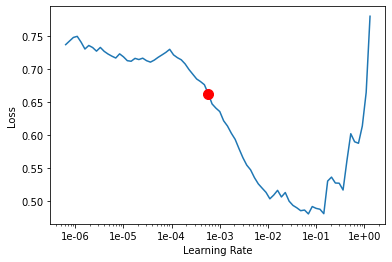

In [ ]:
# train classifier
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

In [ ]:
learn_classifier.fit_one_cycle(5, max_lr=1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.342935,0.162939,0.961435,00:03
1,0.214244,0.253437,0.969507,00:03
2,0.126128,0.148153,0.970404,00:02
3,0.113865,0.197401,0.973094,00:02
4,0.088193,0.317368,0.973094,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

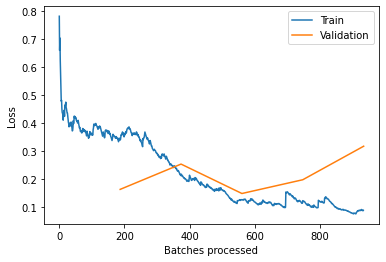

In [ ]:
learn_classifier.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 1.32E-03


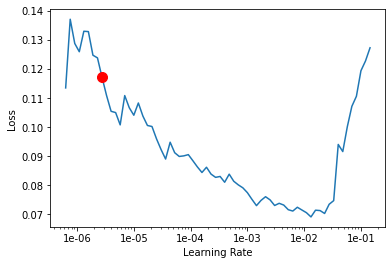

In [ ]:
lang_mod.freeze_to(-1)

learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestion=True)

Test out the classification model on spam and non-spam examples.

In [ ]:
# predict
learn_classifier.predict('did you buy the groceries for dinner? :)')

(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.9871e-28]))

In [ ]:
# predict - not good detect spam - false negative high
learn_classifier.predict('Free entry call back now')

(Category tensor(1), tensor(1), tensor([0.3904, 0.6096]))

Next we will evaluate on all of our validation data.

In [ ]:
# get predictions from validation
valid_preds, valid_label=learn_classifier.get_preds(ds_type=DatasetType.Valid, ordered=True)
valid_preds.shape

torch.Size([1115, 2])

In [ ]:
print(valid_preds)
print(valid_preds.size())
print(valid_label)
print(valid_label.size())

tensor([[3.3936e-02, 9.6606e-01],
        [9.9997e-01, 2.4988e-05],
        [1.0000e+00, 3.3170e-31],
        ...,
        [1.0000e+00, 1.1000e-42],
        [1.0000e+00, 2.1764e-30],
        [1.0000e+00, 7.3014e-33]])
torch.Size([1115, 2])
tensor([1, 0, 0,  ..., 0, 0, 0])
torch.Size([1115])


In [ ]:
# get the valid set accuracy
onelabel_pred = []
for prob in valid_preds.numpy():
    if prob[0] > prob[1]:
        onelabel_pred.append(0)
    else:
        onelabel_pred.append(1)
    
identity = np.mean([p == y for p, y in zip(onelabel_pred, valid_label.numpy())])
print(f'Validation Accuracy: {identity}')

Validation Accuracy: 0.9730941704035875


## Part 1. Evaluate Performance [10pt]

### Part (a) [5pt]

Implement the above helper code for spam detection. 

What is the accuracy obtained with ULMFiT? How does ULMFiT compare to the approach in the first part using only LSTM?

In [ ]:
# get predictions from test set
test_preds, test_label=learn_classifier.get_preds(ds_type=DatasetType.Test, ordered=True)
onelabel_pred = []
for prob in test_preds.numpy():
    if prob[0] > prob[1]:
        onelabel_pred.append(0)
    else:
        onelabel_pred.append(1)
    
identity = np.mean([p == y for p, y in zip(onelabel_pred, df_test['target'].to_numpy())])
print(f'Test Accuracy: {identity}')
# The test accuracy of ULMFiT is about 97.76% whereas my best model from Part 
# A reached 98.38% on the same set of data. ULMFiT seems to be slighly worse 
# than my best model from Part A. 

Test Accuracy: 0.9775583482944344


### Part (b) [5pt]
Provide a confusion matrix of the performance for the two models. How do they compare? Are there any qualitative differences between the performances (i.e. examine the samples for which the models differred)?

In [ ]:
## question
# Confusion Matrix
# True Positive: true label = 1, pred label = 1
# False Positive: true label = 0, pred label = 1
# True Negative: true label = 0, pred label = 0
# False Negative: true label = 1, pred label = 0

# ULMFiT
onelabel_pred = []
for prob in test_preds.numpy():
    if prob[0] > prob[1]:
        onelabel_pred.append(0)
    else:
        onelabel_pred.append(1)

TP, FP, TN, FN = 0,0,0,0
test_label = df_test['target'].to_numpy()
for i in range(1114):
    if onelabel_pred[i] == 1 and test_label[i] == 1:
        TP +=1
    elif onelabel_pred[i] == 1 and test_label[i] == 0:
        FP +=1
    elif onelabel_pred[i] == 0 and test_label[i] == 0:
        TN +=1
    elif onelabel_pred[i] == 0 and test_label[i] == 1:
        FN +=1

from prettytable import PrettyTable
t = PrettyTable(['Pred Neg = ' + str(TN+FN), 'Pred Pos = ' + str(FP+TP), 'Total = ' + str(TN+FP+FN+TP)])
t.add_row(['FN = ' + str(FN), 'TP = ' + str(TP), 'Spam = ' + str(FN+TP)])
t.add_row(['TN = '+ str(TN), 'FP = ' + str(FP), 'Ham = ' + str(TN+FP)])
print(t)
# t = PrettyTable(['TP = '+ str(TP), 'FP = ' + str(FP)])
# t.add_row(['TN = '+ str(TN), 'FN = ' + str(FN)])
# print(t)
# ULMFiT had more number of false negatives, and less number of false positives.
# It is more like to categorize a spam as ham and less likely to catergoize a ham as spam.
# False positive is more harmful than false negative, so ULMFiT seems to be better.

+----------------+----------------+--------------+
| Pred Neg = 981 | Pred Pos = 133 | Total = 1114 |
+----------------+----------------+--------------+
|    FN = 23     |    TP = 131    |  Spam = 154  |
|    TN = 958    |     FP = 2     |  Ham = 960   |
+----------------+----------------+--------------+


In [ ]:
# Model From PartA
def correct_count(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct = 0
    for batch in data:
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
    return correct

# spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)
spam = data_iter(test_spam, 32)

spam_count = 0
for i in spam:
    spam_count += len(i)

TP = correct_count(model3_size120_lr0001_bs64, spam)
FN = spam_count - TP

# non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)
nospam = data_iter(test_nospam, 32)

ham_count = 0
for i in nospam:
    ham_count += len(i)

TN = correct_count(model3_size120_lr0001_bs64, nospam)
FP = ham_count - TN

from prettytable import PrettyTable
t = PrettyTable(['Pred Neg = ' + str(TN+FN), 'Pred Pos = ' + str(FP+TP), 'Total = ' + str(TN+FP+FN+TP)])
t.add_row(['FN = ' + str(FN), 'TP = ' + str(TP), 'Spam = ' + str(spam_count)])
t.add_row(['TN = '+ str(TN), 'FP = ' + str(FP), 'Ham = ' + str(ham_count)])
print(t)
# Our model had less number of false negatives, and more number of false positives.
# It is less like to categorize a spam as ham, and more likely to catergoize a ham as spam.
# False positive is more harmful than false negative, so even our model has 
# slighly higher accuracy, but using ULMFiT is much more safer because it is less 
# likely to categorize ham as spam. 

+----------------+----------------+--------------+
| Pred Neg = 964 | Pred Pos = 150 | Total = 1114 |
+----------------+----------------+--------------+
|    FN = 11     |    TP = 143    |  Spam = 154  |
|    TN = 953    |     FP = 7     |  Ham = 960   |
+----------------+----------------+--------------+


## Part 2. Evaluate on New Data [10pt]

### Part (a) [4pt]
What is your model's prediction of the probability that the SMS message "machine learning is sooo cool!" is spam?

In [ ]:
learn_classifier.predict('machine learning is sooo cool!')
# Think this sentence is ham as 100%

(Category tensor(0), tensor(0), tensor([1., 0.]))

### Part (b) [3 pt] 
Load 5 sample sentences from your spam mail and test it out out the two models you created. How well do they perform?

In [ ]:
# My spam emails are very hard to detect, since the person is like writing a 
# story rather than a simple spam message.

# Similar to previous results, my model is more sensitive to catergoize ham as 
# spam, so it is better at detecting spam than ULMFiT. When there are larger 
# number occurred in the mail like "$16,430,000" (spam 1), "-$27.500.000.00 
# US Dollars" (spam 2), "$US15,500,000" (spam 4), my model can easily noticed 
# this is a spam mail.

# ULMFiT = 0/5 correct
# My Model = 3/5 correct

# Spam 1:
# ULMFiT = 0.8150, 0.1850 (ham, spam) - incorrect
# My Model = 0.0129, 0.9871 (ham, spam) - correct

# Spam 2: 
# ULMFiT = 0.9414, 0.0586 (ham, spam) - incorrect
# My Model = 0.0382, 0.9618 (ham, spam) - correct

# Spam 3: 
# ULMFiT = 0.5191, 0.4809 (ham, spam) - incorrect
# My Model = 0.6394, 0.3606 (ham, spam) - incorrect

# Spam 4:
# ULMFiT = 0.9311, 0.0689 (ham, spam) - incorrect
# My Model = 0.0111, 0.9889 (ham, spam) - correct

# Spam 5:
# ULMFiT = 0.6522, 0.3478 (ham, spam) - incorrect
# My Model = 0.9348, 0.0652 (ham, spam) - incorrect

In [ ]:
spam1 = "Hello My Dear. Please do not feel disturbed for contacting you, based \
on the critical condition I find mine self, though, it's not financial problem, \
but my health, you might have know that cancer is not what to talk home about, \
I am married to Late Engr.Richard Wolfgang who worked with oil company for 15 \
years before he died in the year 2015.We were married for eleven years without \
a child. He died after a brief illness that lasted for five days. Since his \
death I decided not to remarry, When my late husband was alive he deposited \
the sum of $16,430,000 Million {Six Million four hundred and thirty thousand \
dollars} in a bank here, Presently this money is still in the bank. And My \
Doctor told me that I don't have much time to live because of the cancer \
problem, Having known my condition I decided to hand you over this fund to \
take care of the less-privileged people, you will utilize this money the way \
I am going to instruct herein. I want you to take 20 Percent of the total money \
for your personal use While 80% of the money will go to charity people and \
helping the orphanage."

# ULMFiT
print("ULMFiT Prediction spam1: " + str(learn_classifier.predict(spam1)))

tokens = []

for char in spam1:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on spam1: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction spam1: (Category tensor(0), tensor(0), tensor([0.8150, 0.1850]))
PartA Best Model Prediction on spam1: tensor([0.0129, 0.9871], grad_fn=<SelectBackward0>)


In [ ]:
spam2 = "My Dear Good Friend, I have funds worth Twenty Seven Million Five \
Hundred Thousand United State Dollars -$27.500.000.00 US Dollars which i want \
to entrust on you for investment project in your country. If you are willing to \
handle this project on my behalf, kindly reply urgent to enable me provide you \
more details to start the transfer process. Best Regards Mrs Aisha Al-Qaddafi"\

# ULMFiT
print("ULMFiT Prediction on spam2: " + str(learn_classifier.predict(spam2)))

# Part A Best Model
tokens = []
for char in spam2:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on spam2: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on spam2: (Category tensor(0), tensor(0), tensor([0.9414, 0.0586]))
PartA Best Model Prediction on spam2: tensor([0.0382, 0.9618], grad_fn=<SelectBackward0>)


In [ ]:
spam3 = "We are offering Corporate and Personal Loans at a 2.5% Interest Rate \
for a duration of 10 to 15 years. We also pay a 1.2% commission to brokers who \
introduce project owners for finance or other opportunities. I will give you \
more details upon the receipt of your response, to prove myself and my office.\
Regards, Mr. Aboob Mohammed."

# ULMFiT
print("ULMFiT Prediction on spam3: " + str(learn_classifier.predict(spam3)))

# Part A Best Model
tokens = []
for char in spam3:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on spam3: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on spam3: (Category tensor(0), tensor(0), tensor([0.5191, 0.4809]))
PartA Best Model Prediction on spam3: tensor([0.6394, 0.3606], grad_fn=<SelectBackward0>)


In [ ]:
spam4 = "Can you invest this money and also help the poor ? The amount value \
at $15.5million Dollars  ($US15,500,000), left in his account still unclaimed,\
if you know that you are capable to invest this fund into any  profitable \
business in your country kindly send me your details information as listed \
below to enable me draft you an application form of claim along with the \
deposit certificate which you are going to fill with your bank account \
detail necessary and contact the HSBC Bank in Italy  for immediate transfer \
of the Amounted sum into your bank account direct."

# ULMFiT
print("ULMFiT Prediction on spam4 : " + str(learn_classifier.predict(spam4)))

# Part A Best Model
tokens = []
for char in spam4:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on spam4: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on spam4 : (Category tensor(0), tensor(0), tensor([0.9311, 0.0689]))
PartA Best Model Prediction on spam4: tensor([0.0111, 0.9889], grad_fn=<SelectBackward0>)


In [ ]:
spam5 = "We are closing all old version of our Mailbox as from June 24th. \
Please follow the link below to update your account. Thank You. Please do not\
reply to this message. Mail sent to this address cannot be answered"

# ULMFiT
print("ULMFiT Prediction on spam5 : " + str(learn_classifier.predict(spam5)))

# Part A Best Model
tokens = []
for char in spam5:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on spam5: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on spam5 : (Category tensor(0), tensor(0), tensor([0.6522, 0.3478]))
PartA Best Model Prediction on spam5: tensor([0.9348, 0.0652], grad_fn=<SelectBackward0>)


### Part (c) [3pt]
Load 5 sample sentences from your regular mail and test it out out the two models you created. How well do they perform?

In [ ]:
# I try to find my regular mail which looks like a spam to evalaute both models.

# Both model showed similar performance. However, ULMFiT tended to give more
# neutral probability and my model gave more extreme probability. So sometimes 
# my model can be totally wrong (in spam 5 with predicting spam as 0.71), but 
# ULMFiT usually does not make a totally wrong predicition (in spam 3 with 
# predicting spam as 0.56), which is more neutral response. ULMFiT is better and safer to use.

# ULMFiT = 4/5 correct
# My Model = 4/5 correct

# Spam 1:
# ULMFiT = 0.8191, 0.1809 (ham, spam) - correct
# My Model = 0.9765, 0.0235 (ham, spam) - correct

# Spam 2: 
# ULMFiT = 0.6570, 0.3430 (ham, spam) - correct
# My Model = 0.9883, 0.0117 (ham, spam) - correct

# Spam 3: 
# ULMFiT = 0.4384, 0.5616 (ham, spam) - incorrect
# My Model = 0.9958, 0.0042 (ham, spam) - correct

# Spam 4:
# ULMFiT = 0.9771, 0.0229 (ham, spam) - correct
# My Model = 0.9898, 0.0102 (ham, spam) - correct

# Spam 5:
# ULMFiT = 0.6689, 0.3311 (ham, spam) - correct
# My Model = 0.2883, 0.7117 (ham, spam) - incorrect

In [ ]:
ham1 = "You’re invited to a night of Real Talk with engineering alumni about \
the intersection of engineering skills and social change.  Equip yourself with \
knowledge that can help you make decisions about when to act for social change \
versus when to step back. And, learn how to find your way when you want to \
contribute your engineering skills but don’t know how."

# ULMFiT
print("ULMFiT Prediction on ham1: " + str(learn_classifier.predict(ham1)))

# Part A Best Model
tokens = []
for char in ham1:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on ham1: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on ham1: (Category tensor(0), tensor(0), tensor([0.8191, 0.1809]))
PartA Best Model Prediction on ham1: tensor([0.9765, 0.0235], grad_fn=<SelectBackward0>)


In [ ]:
ham2 = "Hi all, following the instructions below, please log in to PCS account \
and update your contact information. Please also update your ORCID id if you \
have one. the link is here. "

# ULMFiT
print("ULMFiT Prediction on ham2: " + str(learn_classifier.predict(ham2)))

# Part A Best Model
tokens = []
for char in ham2:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on ham2: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on ham2: (Category tensor(0), tensor(0), tensor([0.6570, 0.3430]))
PartA Best Model Prediction on ham2: tensor([0.9883, 0.0117], grad_fn=<SelectBackward0>)


In [ ]:
ham3 = "Dear Miss Hu: This e-mail has been generated by the entry of your email \
address into the 'Password Help' box on your site log in page."

# ULMFiT
print("ULMFiT Prediction on ham3: " + str(learn_classifier.predict(ham3)))

# Part A Best Model
tokens = []
for char in ham3:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on ham3: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on ham3: (Category tensor(1), tensor(1), tensor([0.4384, 0.5616]))
PartA Best Model Prediction on ham3: tensor([0.9958, 0.0042], grad_fn=<SelectBackward0>)


In [ ]:
ham4 = "This EMail is sent to all University of Toronto Engineering students\
regarding a new printing option available to all currently residing in Canada. \
If you are currently outside Canada this printing environment is not available \
NOTE: Your ECF print quota only applies to in-lab printing. Staples printing \
has a $0.06 per page fee...which is less than their normal printing fee.to you."

# ULMFiT
print("ULMFiT Prediction on ham4: " + str(learn_classifier.predict(ham4)))

# Part A Best Model
tokens = []
for char in ham4:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on ham4: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on ham4: (Category tensor(0), tensor(0), tensor([0.9771, 0.0229]))
PartA Best Model Prediction on ham4: tensor([0.9898, 0.0102], grad_fn=<SelectBackward0>)


In [ ]:
ham5 = "Dear Ms. Hu, Our records indicate that you have an incomplete submission\
 in our system that has not been accessed for 365 days. If you intend to move \
 forward with the submission, please login to the system within the next 60 \
 days and proceed with the submission. Otherwise, the submission will be \
 removed from our system in 60 days.When prompted for a password, enter the \
 following temporary PIN."

# ULMFiT
print("ULMFiT Prediction on ham5: " + str(learn_classifier.predict(ham5)))

# Part A Best Model
tokens = []
for char in ham5:
  tokens.append(torch.tensor(text_field.vocab.stoi[char]))
x = torch.stack(tokens).unsqueeze_(0)
print(f"PartA Best Model Prediction on ham5: {F.softmax(model3_size120_lr0001_bs64(x), dim=1)[0]}")

ULMFiT Prediction on ham5: (Category tensor(0), tensor(0), tensor([0.6689, 0.3311]))
PartA Best Model Prediction on ham5: tensor([0.2883, 0.7117], grad_fn=<SelectBackward0>)


### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [12]:
%%shell
jupyter nbconvert --to html LAB_4_Sequential_Data.ipynb

[NbConvertApp] Converting notebook LAB_4_Sequential_Data.ipynb to html
[NbConvertApp] Writing 931041 bytes to LAB_4_Sequential_Data.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus